In [51]:
import numpy as np

from keras.layers import Input, Convolution1D, Dot, Dense, Activation, Concatenate,LSTM
from keras.models import Model

In [3]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'D:/个人学习/data/fra-eng/fra.txt'

In [5]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [31]:
lines

['Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)',
 'Hi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)',
 'Hi.\tSalut.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)',
 'Run!\tCours\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)',
 'Run!\tCourez\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)',
 'Who?\tQui ?\tCC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #4366796 (gillux)',
 'Wow!\tÇa alors\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #374631 (zmoo)',
 'Fire!\tAu feu !\tCC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #4627939 (sacredceltic)',
 "Help!\tÀ l'aide\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #128430 (sysko)",
 'Jump.\tSaute.\tCC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishi

In [32]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text,_ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 20000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [33]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [39]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [45]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
# Encoder
x_encoder = Convolution1D(256, kernel_size=3, activation='relu',
                          padding='causal')(encoder_inputs)
x_encoder = Convolution1D(256, kernel_size=3, activation='relu',
                          padding='causal', dilation_rate=2)(x_encoder)
x_encoder = Convolution1D(256, kernel_size=3, activation='relu',
                          padding='causal', dilation_rate=4)(x_encoder)

decoder_inputs = Input(shape=(None, num_decoder_tokens))
# Decoder
x_decoder = Convolution1D(256, kernel_size=3, activation='relu',
                          padding='causal')(decoder_inputs)
x_decoder = Convolution1D(256, kernel_size=3, activation='relu',
                          padding='causal', dilation_rate=2)(x_decoder)
x_decoder = Convolution1D(256, kernel_size=3, activation='relu',
                          padding='causal', dilation_rate=4)(x_decoder)
# Attention
attention = Dot(axes=[2, 2])([x_decoder, x_encoder])
attention = Activation('softmax')(attention)

context = Dot(axes=[2, 1])([attention, x_encoder])
decoder_combined_context = Concatenate(axis=-1)([context, x_decoder])

decoder_outputs = Convolution1D(64, kernel_size=3, activation='relu',
                                padding='causal')(decoder_combined_context)
decoder_outputs = Convolution1D(64, kernel_size=3, activation='relu',
                                padding='causal')(decoder_outputs)
# Output
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

# Run training
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 93)     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, None, 256)    71680       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 256)    54784       input_1[0][0]                    
_________________________________________________________________________________________

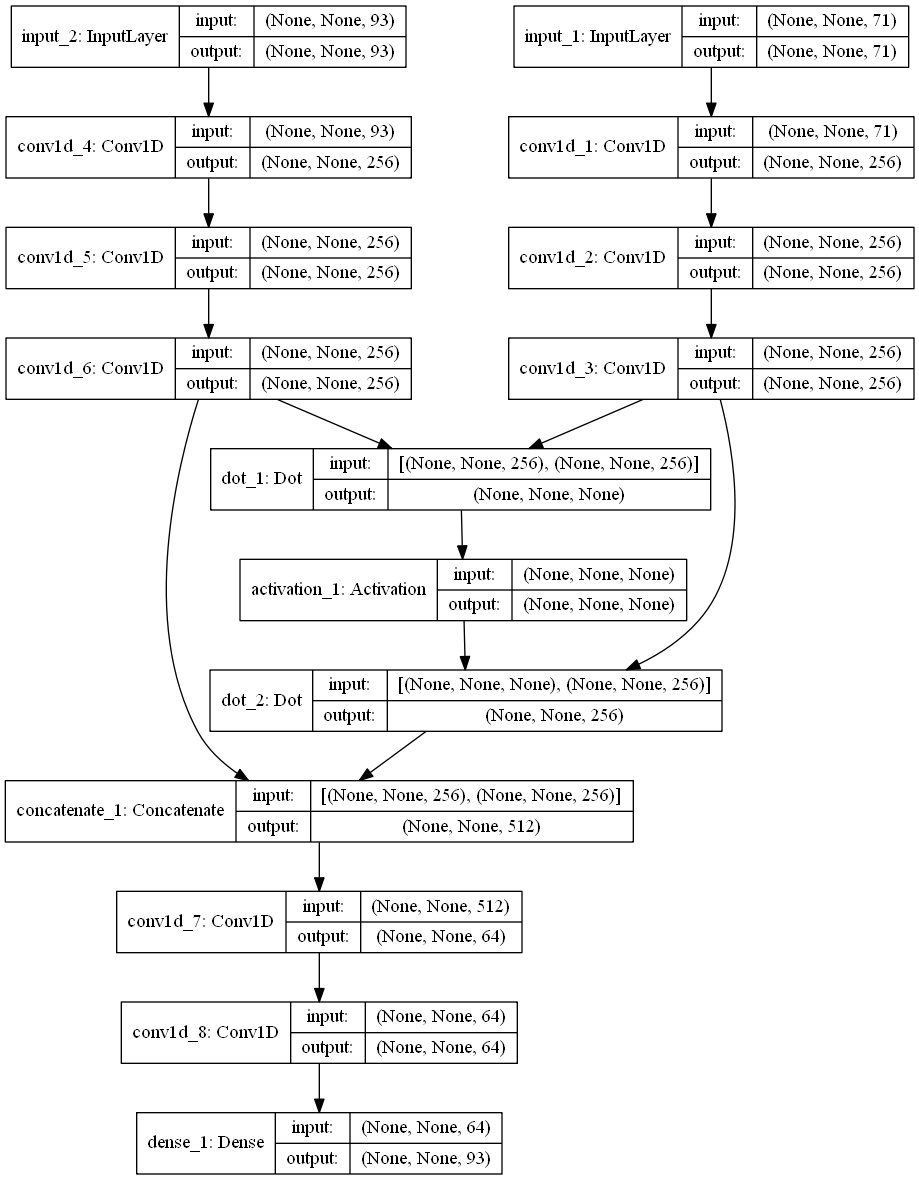

In [46]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='seq2seq_cnn.png',show_shapes=True)

In [48]:
epochs = 1
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('cnn_s2s.h5')

Train on 16000 samples, validate on 4000 samples
Epoch 1/1
16000/16000 [==============================] - 67s 4ms/step - loss: 0.6230 - val_loss: 0.5809


In [49]:
# Define sampling models
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

nb_examples = 100
in_encoder = encoder_input_data[:nb_examples]
in_decoder = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

in_decoder[:, 0, target_token_index["\t"]] = 1

predict = np.zeros(
    (len(input_texts), max_decoder_seq_length),
    dtype='float32')

for i in range(max_decoder_seq_length - 1):
    predict = model.predict([in_encoder, in_decoder])
    predict = predict.argmax(axis=-1)
    predict_ = predict[:, i].ravel().tolist()
    for j, x in enumerate(predict_):
        in_decoder[j, i + 1, x] = 1

for seq_index in range(nb_examples):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    output_seq = predict[seq_index, :].ravel().tolist()
    decoded = []
    for x in output_seq:
        if reverse_target_char_index[x] == "\n":
            break
        else:
            decoded.append(reverse_target_char_index[x])
    decoded_sentence = "".join(decoded)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Sois vous anterie.
-
Input sentence: Hi.
Decoded sentence: Sois vous antiri.
-
Input sentence: Hi.
Decoded sentence: Sois vous antiri.
-
Input sentence: Run!
Decoded sentence: C'est cis de !
-
Input sentence: Run!
Decoded sentence: C'est cis de !
-
Input sentence: Who?
Decoded sentence: Sois vous antien.
-
Input sentence: Wow!
Decoded sentence: C'est cisrir.
-
Input sentence: Fire!
Decoded sentence: Sois vous antiri.
-
Input sentence: Help!
Decoded sentence: Sois vous pruter.
-
Input sentence: Jump.
Decoded sentence: Sois vous poutie !
-
Input sentence: Stop!
Decoded sentence: Sois vous antiri.
-
Input sentence: Stop!
Decoded sentence: Sois vous antiri.
-
Input sentence: Stop!
Decoded sentence: Sois vous antiri.
-
Input sentence: Wait!
Decoded sentence: Sois vous poutie !
-
Input sentence: Wait!
Decoded sentence: Sois vous poutie !
-
Input sentence: Go on.
Decoded sentence: Sois vous pas !
-
Input sentence: Go on.
Decoded sentence: Sois vous pas 

In [50]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [71]:
latent_dim = 256  

input1 = Input(shape=(None, num_encoder_tokens))

_, state_h, state_c =  LSTM(latent_dim, return_state=True)(input1)
encoder_states = [state_h, state_c]

input2 = Input(shape=(None, num_decoder_tokens))

x = LSTM(latent_dim, return_sequences=True)(input2,initial_state=encoder_states)

output = Dense(num_decoder_tokens, activation='softmax')(x)

model = Model([input1, input2], output)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           (None, None, 93)     0                                            
__________________________________________________________________________________________________
lstm_32 (LSTM)                  [(None, 256), (None, 335872      input_36[0][0]                   
__________________________________________________________________________________________________
lstm_33 (LSTM)                  (None, None, 256)    358400      input_37[0][0]                   
                                                                 lstm_32[0][1]             

In [73]:
latent_dim = 256  # Latent dimensionality of the encoding space.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           (None, None, 93)     0                                            
__________________________________________________________________________________________________
lstm_34 (LSTM)                  [(None, 256), (None, 335872      input_38[0][0]                   
__________________________________________________________________________________________________
lstm_35 (LSTM)                  [(None, None, 256),  358400      input_39[0][0]                   
                                                                 lstm_34[0][1]             

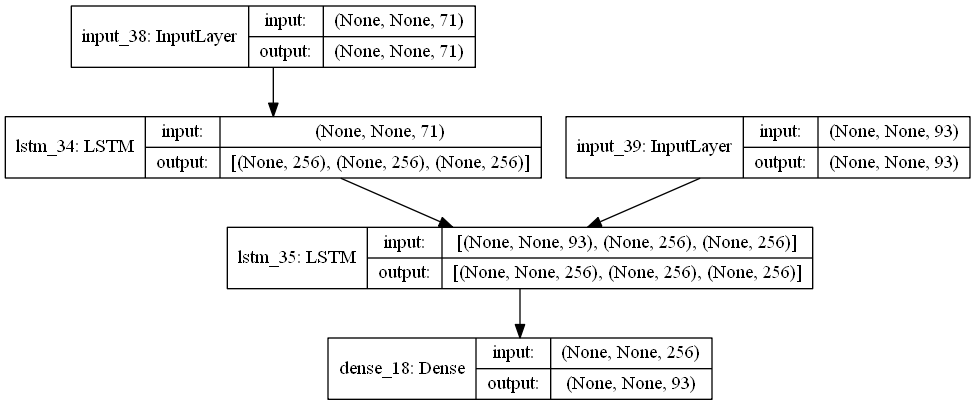

In [74]:
plot_model(model, to_file='seq2seq_lstm.png',show_shapes=True)

In [56]:
epochs=2
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('lstm_s2s.h5')

Train on 16000 samples, validate on 4000 samples
Epoch 1/2
16000/16000 [==============================] - 63s 4ms/step - loss: 1.0447 - acc: 0.7429 - val_loss: 0.8671 - val_acc: 0.7538
Epoch 2/2
16000/16000 [==============================] - 73s 5ms/step - loss: 0.6626 - acc: 0.8122 - val_loss: 0.6482 - val_acc: 0.8092
